# Travelling Salesman Problem

#### Importación de libraría necesarias para la creación del problema

In [12]:
#Import libraries
import pandas
import itertools 
import numpy
import random
import networkx

#Import graphing libraries
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

#### Creación del modelo con DOcplex
Parámetros
\begin{equation}
c_ij = \text{distance from i to j}
\end{equation}
Variables de decisión
\begin{equation}
x_{ij} = \begin{cases} 0, & \text{if the path from i to j is selected}  \\1, & \text{otherwise}\end{cases} \text{   }\forall i = 1,..,n \text{ , } j = 1,..,n\end{equation}

Función Objetivo
\begin{equation}
\text{Min} \sum\limits_{i=1}^n \sum\limits_{i\neq j,j=1}^n c_{ij}x_{ij}

\end{equation}

Restricciones
\begin{equation}
\sum\limits_{i=1,i\neq j}^n x_{ij} = 1,\forall j = 1..n
\end{equation}
\begin{equation}
\sum\limits_{j=1,j\neq i}^n x_{ij} = 1,\forall i = 1..n
\end{equation}
\begin{equation}
\sum\limits_{i\in S,j\neq i,j\in S} x_{ij} \leq \lvert S \rvert - 1,\text{   } \forall S\subset {1,..,n},2\leq \lvert S \rvert \leq n-2
\end{equation}


In [ ]:
from docplex.mp.model import Model

#create the base model
def tsp(data, max_length):
    m = Model(name='tsp',log_output=False)
    m.parameters.threads.set(1)
    
    all_locations = set(data.point_from.unique()).union(set(data.point_to.unique()))
    
    ####VARIABLES####
    data['travel_on'] = m.binary_var_list([(row.point_from, row.point_to) for row in data.itertuples()], name = 'travel_on')
    
    ####OBJECTIVE####
    distance_traveled = m.sum([row.travel_on * row.distance for row in data.itertuples()]) 
    m.add_kpi(distance_traveled, "distance")
    
    m.minimize(distance_traveled)
    ####CONSTRAINTS####
    #force each location to only have one outgoing edge
    for start_point in all_locations:
        m.add_constraint(m.sum([row.travel_on for row in data[data.point_from == start_point].itertuples()]) == 1, \
            'outgoing_edge_%s' % start_point)

    #force each location to only have one incoming edge
    for end_point in all_locations:
        m.add_constraint(m.sum([row.travel_on for row in data[data.point_to == end_point].itertuples()]) == 1, \
            'incoming_edge_%s' % end_point)

    return m

#update the parameters, solve the model, and return the results
def update_and_solve(m, data, mipgap = 0.0001):
    m.parameters.mip.tolerances.mipgap.set(mipgap)
    m.parameters.timelimit = 600
    m.solve()
    data['travel_on_val'] = [var.solution_value for var in data.travel_on.values]

def add_cycle_breaking_constraints(m,subtour_id, data):
    g = networkx.DiGraph()
    g.add_edges_from([(row.point_from,row.point_to) for row in data[data.travel_on_val > 0.5].itertuples()])
    num_cycles = 0
    longest_cycle = None
    subtours = {}
    for cycle in networkx.simple_cycles(g):
        cycleLength = len(cycle)
        num_cycles += 1
        subtours[subtour_id] = cycle
        subtour_id += 1
    if num_cycles == 1: #finished
        return m.kpis_as_dict()['distance'], cycle, subtour_id
    else:
        for new_subtour in subtours.keys():
            cycle = subtours[new_subtour]
            idxs = data[(data.point_from.isin(cycle)) & (data.point_to.isin(cycle)) & (data.travel_on_val > 0.5)].index.values
            m.add_constraint(m.sum(data.loc[idxs,'travel_on'].values) <= len(cycle) - 1,\
                'subtour_elimintaion_%d' % subtour_id)
        return m.kpis_as_dict()['distance'], [], subtour_id
    
def distance_tsp(data, max_length):
    m = tsp(data, max_length)
    mipgap = 0.1
    subtour_id = 0
    iteracion = 0
    max_iter = 500
    estado_iter = ''
    update_and_solve(m, data, mipgap = mipgap)
    distance, tour, subtour_id = add_cycle_breaking_constraints(m,subtour_id, data)
    if len(tour) == max_length:
        mipgap = mipgap - 0.01
    while (len(tour) < max_length or mipgap > 0.009) and iteracion < max_iter:
        update_and_solve(m, data, mipgap = mipgap)
        distance, tour, subtour_id = add_cycle_breaking_constraints(m,subtour_id, data)
        if len(tour) == max_length:
            mipgap = 0
        iteracion = iteracion + 1
    if iteracion == max_iter:
        estado_iter = 'SIN SOLUCION'
    else:
        estado_iter='OPTIMO'
    return distance, tour, estado_iter

#### Creación de coordenadas aleatorias
Se definen p puntos con coordenadas aleatorias. Estos puntos serán los lugares a visitar

In [13]:
p = 20
df = pandas.DataFrame({'X':[random.randrange(100) for i in range(p)],'Y':[random.randrange(100) for i in range(p)]})

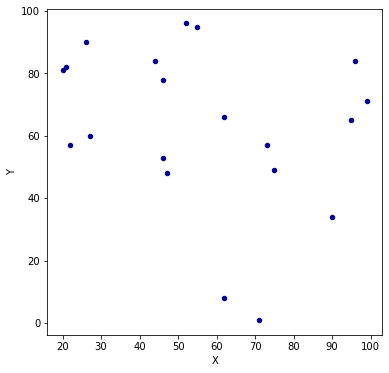

In [14]:
df.plot(kind='scatter', x='X', y='Y', figsize=(6, 6), color='darkblue')

Se definen todas las posibles combinaciones entre dos puntos

In [15]:
perm = [x for x in itertools.permutations(range(p), 2)]

Se definen las distancias para cada par de puntos

In [16]:
data = pandas.DataFrame(columns=['point_from','point_to','distance'])

for i in range(len(perm)):
    p1 = perm[i][0]
    p2 = perm[i][1]
    data.loc[i] = p1 , p2 , \
    round(numpy.lib.scimath.sqrt((df.loc[p1,'X'] - df.loc[p2,'X'])**2+(df.loc[p1,'Y'] - df.loc[p2,'Y'])**2),2)

data.head(5)

,point_from,point_to,distance
0,0.0,1.0,49.20
1,0.0,2.0,14.42
2,0.0,3.0,35.34
3,0.0,4.0,26.68
4,0.0,5.0,3.16


#### Ejecución de modelo - DOcplex
Por medio del modelo definido en tsp_model, se obtiene la ruta óptima para los puntos definidos

In [17]:
max_length = len(set(data.point_from.unique()).union(set(data.point_to.unique())))
distance, tour, estado = distance_tsp(data, max_length)

#### Solución de modelo - DOcplex
La solución del modelo nos retornará la distancia recorrida, el orden de recorrido de los puntos y el estado del modelo (óptimo o sin solución óptima)

In [18]:
distance

362.94999999999993

In [19]:
tour

[0.0,
 4.0,
 12.0,
 3.0,
 1.0,
 7.0,
 16.0,
 6.0,
 10.0,
 9.0,
 15.0,
 13.0,
 17.0,
 8.0,
 14.0,
 19.0,
 11.0,
 18.0,
 2.0,
 5.0]

In [20]:
estado

'OPTIMO'

#### Solución gráfica 
Para evaluar la solución, graficamos las rutas definidas por la soluci´´on del modelo

In [21]:
def plot_tsp(df,points, style='bo-'):
    "Plot lines to connect a series of points."
    plt.plot([df.loc[p,'X'] for p in points], [df.loc[p,'Y'] for p in points], style)
    plt.axis('scaled'); plt.axis('off')

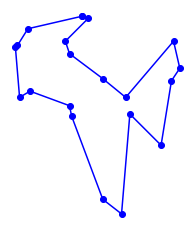

In [22]:
first_point= tour[0]
tour.append(first_point)
plot_tsp(df,tour)